# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Convolutional Neural Network - Classifiying CIFAR-10 (40 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch.
2. Evaluate your model using a confusion matrix.
3. Solve the localization task using regression.

### Data Preprocessing

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
      deer        cat       deer      plane


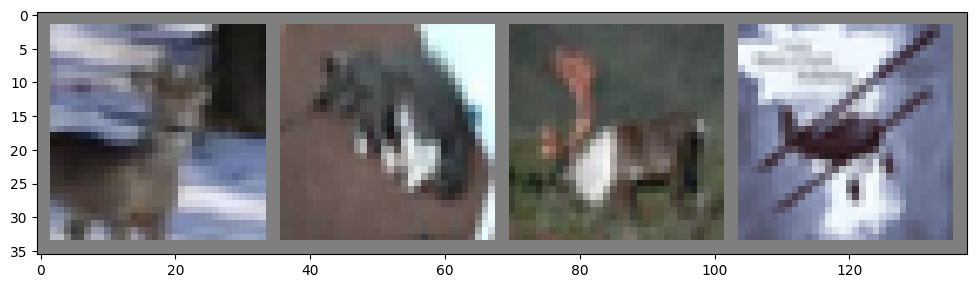

In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

### Construct a CNN in PyTorch

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
2. Use your intuition from the previous exercises and additional sources such as the stackoverflow, Medium, etc. - **do not try to perform a massive grid search.**
3. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
4. It is not allowed to use famous models that have been already implemented by PyTorch (resnet, densenet, alexnet, etc).
5. Make sure your code runs reasonably fast (no more than 15 minutes on CPU).
6. Use the best architecture you find and train it for 1-10 epochs. 
7. Visualize the loss and accuracy of your network during training. You can use matplotlib.
8. You should get above 60% accuracy on the test set.
**(20 points)**

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.pool = nn.MaxPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3) 
        self.conv4 = nn.Conv2d(128, 256, 3)
        
        self.fc1 = nn.Linear(5*5*256, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10) 
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.conv1(x) # 32x32x3 -> 30x30x32
        x = self.relu(x)
        x = self.conv2(x) # 30x30x32 -> 28x28x64
        x = self.relu(x)
        x = self.pool(x) # 28x28x64 -> 14x14x64

        x = self.conv3(x) # 14x14x64 -> 12x12x128
        x = self.relu(x)
        x = self.conv4(x) # 12x12x128 -> 10x10x256
        x = self.relu(x)
        x = self.pool(x) # 10x10x256 -> 5x5x256

        x = self.flatten(x) 
        x = self.fc1(x) # 5x5x256 -> 1024
        x = self.relu(x)
        x = self.fc2(x) # 1024 -> 512
        x = self.relu(x)
        x = self.fc3(x) # 512 -> 10
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net()
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   # 
#############################################################################
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Epoch: 1, Loss: 1.411, Accuracy: 0.480
Epoch: 2, Loss: 0.902, Accuracy: 0.682
Epoch: 3, Loss: 0.666, Accuracy: 0.767
Epoch: 4, Loss: 0.503, Accuracy: 0.824
Epoch: 5, Loss: 0.372, Accuracy: 0.870
Epoch: 6, Loss: 0.253, Accuracy: 0.912


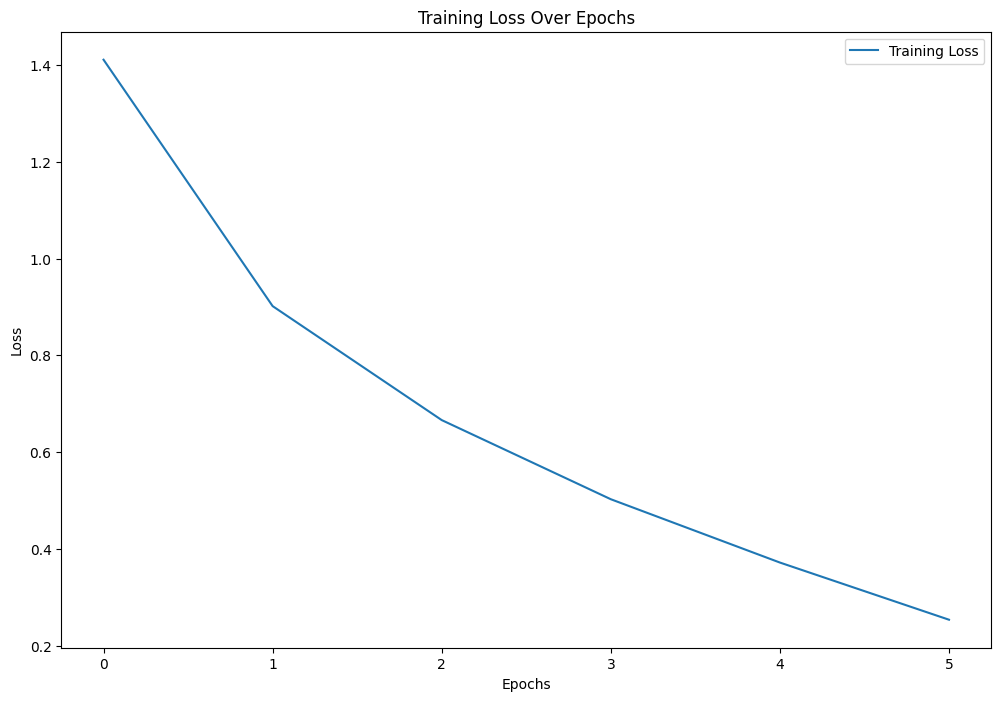

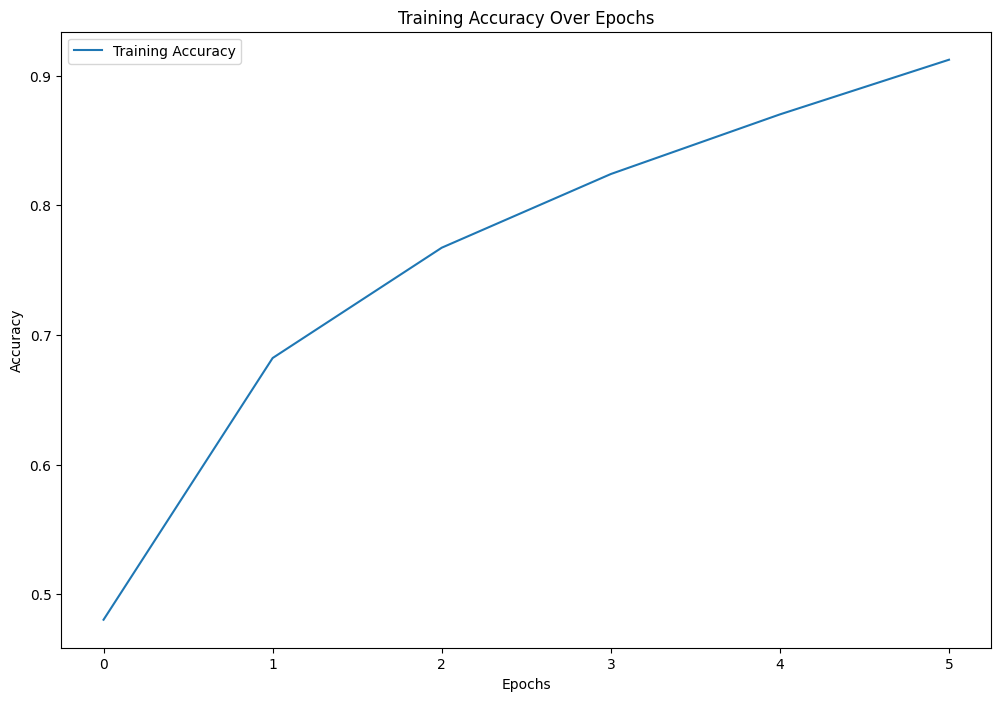

In [5]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################
# Lists to store training loss and accuracy
train_loss_values = []
train_acc_values = []

for epoch in range(6):
    running_loss = 0.0
    accuracy = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        accuracy += (outputs.argmax(dim=1) == labels).sum().item() / len(labels)

    
    print('Epoch: %d, Loss: %.3f, Accuracy: %.3f' % (epoch + 1, running_loss / len(trainloader), accuracy / len(trainloader)))
                          
    # Calculate average loss and accuracy for the epoch and store it
    avg_loss = running_loss / len(trainloader)
    train_loss_values.append(avg_loss)
    avg_accuracy = accuracy / len(trainloader)
    train_acc_values.append(avg_accuracy)

# Plotting the training loss
plt.plot(train_loss_values, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the training accuracy
plt.plot(train_acc_values, label='Training Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Model evaluation

Calculate the model accuracy and print a confusion matrix where in y axis represents the real category and the x axis represents the predicted category. **(10 points)** 

In [6]:
confusion_matrix = np.zeros([10,10], int)
model_accuracy = 0
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
for i, data in enumerate(testloader):
    inputs, labels = data
    outputs = net(inputs)
    predicted = outputs.argmax(dim=1)
    model_accuracy += (predicted == labels).sum().item()
    for j in range(len(labels)):
        confusion_matrix[labels[j]][predicted[j]] += 1

model_accuracy = model_accuracy / len(testset) * 100
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################
print('Model accuracy on {0} test images: {1:.2f}%'.format(len(testset), model_accuracy))

Model accuracy on 10000 test images: 75.98%


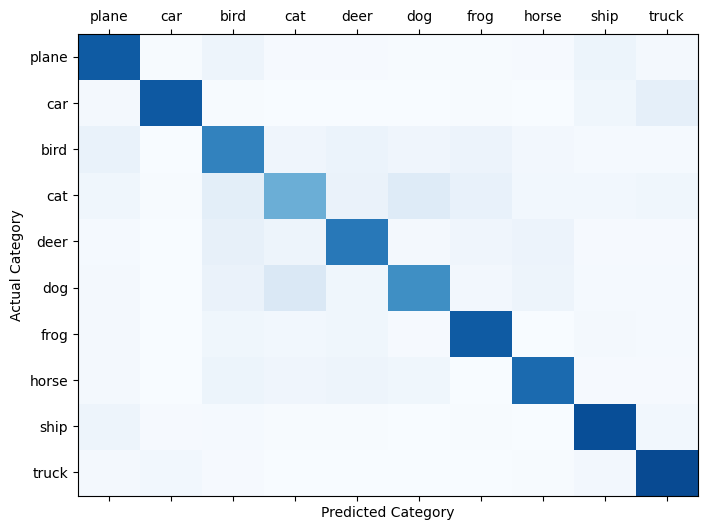

In [7]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.matshow(confusion_matrix, aspect='auto', vmin=0, vmax=1000, cmap=plt.get_cmap('Blues'))
plt.ylabel('Actual Category')
plt.yticks(range(10), classes)
plt.xlabel('Predicted Category')
plt.xticks(range(10), classes)
plt.show()

##**Question:** 
Describe your experiments.
What parameters have you experimented with? What works and what doesn't? Why?   **(5 Points)**

**Your answer:** *Fill this in*

**Experiment 1:**
- **Architecture:** Deep network with only convolutional layers and activations.
- **Performance:** 40% accuracy on both the training and test sets.
- **Analysis:** The architecture consists of a series of convolutional layers without any pooling or fully connected layers. The poor performance on both training and test sets indicates that this design lacks the capability to use the learned meaningful hierarchical features for effective image classification.

   - **Architecture Details:**
      - **Input Dimension:** (3, 32, 32)
      - **Convolutional Layer 1:** (3, 32, 32) -> Conv (3x3, 4 filters) -> ReLU
      - **Convolutional Layer 2:** (4, 30, 30) -> Conv (3x3, 5 filters) -> ReLU
      - **Convolutional Layer 3:** (5, 28, 28) -> Conv (3x3, 6 filters) -> ReLU
      - **Convolutional Layer 4:** (6, 26, 26) -> Conv (3x3, 7 filters) -> ReLU
      - **Convolutional Layer 5:** (7, 24, 24) -> Conv (3x3, 8 filters) -> ReLU
      - **Convolutional Layer 6:** (8, 22, 22) -> Conv (3x3, 9 filters) -> ReLU
      - **Convolutional Layer 7:** (9, 20, 20) -> Conv (3x3, 10 filters) -> ReLU
      - **Final Convolutional Layer:** (10, 18, 18) -> Conv (3x3, 10 filters, stride=2) -> ReLU  x3
      - **Flatten Layer:** (10, 1, 1) -> Flatten -> 10
     
   - **Activation Function:**
      - ReLU is applied after each convolutional layer.

   - **Stride in Final Convolutional Layer:**
      - The final convolutional layer has a stride of 2, reducing the spatial dimensions.

- **Connection to Other Experiments:**
  - Experiment 1 demonstrates the limitation of relying solely on convolutional layers without pooling or fully connected layers for image classification.
  - It serves as a baseline for understanding the importance of incorporating diverse layer types in neural network architectures.

---

**Experiment 2:**
- **Architecture:** Moderately deep network with a combination of convolutional, pooling, and fully connected layers.
- **Performance:** 91.5% accuracy on the training set and 75% accuracy on the test set.
- **Analysis:** This model significantly outperforms Experiment 1 by incorporating a combination of convolutional, pooling, and fully connected layers. However, there is a notable overfitting issue with a 15% gap between the training and test accuracies. The architecture's complexity allows it to learn intricate features from the training data, but it struggles to maintain the high accuracy rate on unseen data.

   - **Architecture Details:**
      - **Input Dimension:** (3, 32, 32)
      - **Convolutional Layer 1:** (3, 32, 32) -> Conv (3x3, 32 filters) -> ReLU
      - **Convolutional Layer 2:** (32, 30, 30) -> Conv (3x3, 64 filters) -> ReLU
      - **Pooling Layer:** (64, 28, 28) -> MaxPool (2x2)
      - **Convolutional Layer 3:** (64, 14, 14) -> Conv (3x3, 128 filters) -> ReLU
      - **Convolutional Layer 4:** (128, 12, 12) -> Conv (3x3, 256 filters) -> ReLU
      - **Pooling Layer:** (256, 10, 10) -> MaxPool (2x2)
      - **Flatten Layer:** (256, 5, 5) -> Flatten
      - **Fully Connected Layer 1:** (5x5x256) -> Linear (1024 neurons) -> ReLU
      - **Fully Connected Layer 2:** (1024) -> Linear (512 neurons) -> ReLU
      - **Fully Connected Layer 3 (Output Layer):** (512) -> Linear (10 neurons)

   - **Activation Function:**
      - ReLU is applied after each convolutional layer and fully connected layer.

   - **Pooling Operation:**
      - Max pooling with a kernel size of 2x2 is applied after the second and fourth convolutional layers.

- **Connection to Other Experiments:**
  - Experiment 2 establishes a baseline for a successful architecture by combining convolutional, pooling, and fully connected layers.

---

**Experiment 3:**
- **Architecture:** Similar to Experiment 2 but with dropout applied to fully connected layers.
- **Performance:** 89% accuracy on the training set and 75% accuracy on the test set.
- **Analysis:** Experiment 3 introduces dropout to address the overfitting observed in Experiment 2. While dropout helps reduce the overfitting gap, it doesn't significantly improve the test accuracy. Further adjustments to dropout rates or additional regularization techniques might be necessary to achieve a better balance between training and test performance.

   - **Architecture Details:**
      - Similar to Experiment 2 with the addition of Dropout layers after the first and second fully connected layers.

   - **Dropout Layer:**
      - Dropout with a probability of 0.2.

- **Connection to Other Experiments:**
  - Experiment 3 attempts to mitigate overfitting through dropout but doesn't completely bridge the gap between training and test accuracies in Experiment 2.
---

**Summary:**
- The most successful architecture involves a combination of convolutional, pooling, and fully connected layers.
- Overfitting remains a challenge, and further regularization or model complexity adjustments might be explored for better generalization.
- As the best solution I choosed experiment number 2 with 6 epoch train.

##**Question:** 
What can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy? **(5 Points)**

**Your answer:** *Fill this in*
The confusion matrix serves as a comprehensive tool, breaking down model performance across various classes and revealing specific strengths and weaknesses. In my case, the model excels in classifying trucks but faces challenges distinguishing between dogs and cats.

While accuracy offers an overall perspective, it lacks the granular insights provided by the confusion matrix. An illustrative example is the issue of Class Imbalance, where accuracy can be misleading by favoring the majority class.

In summary, the synergy between the confusion matrix and accuracy results in a nuanced and context-aware evaluation. The confusion matrix unveils detailed class-specific performance, addressing limitations associated with accuracy, and enhancing the overall understanding of the model's effectiveness.

# Localization as Regression (60 points)

In the next part, we will use a well known architecture called ResNet18 that was trained on ImageNet, a dataset far more rich than CIFAR10. ImageNet has 1,000 classes and 1,000,000 images. In this part, we will use the features extracted from ResNet18 to localize and classify images of cats and dogs. 

Using a pretrained network as a building block for a more complicated task is at the heart of neural networks today. By leveraging the features ResNet18 extracts, we can train a model that can correctly classify and localize cats and dogs using very few images. 

In [4]:
import torchvision.transforms as transforms
from data.dataloader import *
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.models as models
import torch.nn as nn
from PIL import Image
import collections
import time
import copy
import sys
import os

To load ResNet18 with the pretrained weights, use the following line. You are welcome to try different architectures, however they might require different input sizes or normalization.

The first time you run this cell the weights will be downloaded.

In [5]:
resnet18 = resnet18(weights=ResNet18_Weights.DEFAULT)

ResNet takes as input images of size (224,224). We will use PyTorch Transforms to change the size of the images. When ResNet18 was trained on ImageNet, the images were normalized using the mean and standard deviation of the images. In order to properly use the weights, we will use the same normalization.

In [6]:
data_transforms = {
    'train': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalizing according to imagenet
    ]),
    'val': transforms.Compose([
        Rescale((224,224)),
        ToTensor(),
        Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
root_dir = "data/animals/"
datasets = {x: VOCDetection(root_dir, image_set=x, transform=data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=32, shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
classes = datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(dataset_sizes)

{'train': 636, 'val': 158}


In [7]:
# Get a batch of training data
sample = next(iter(dataloaders['train']))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

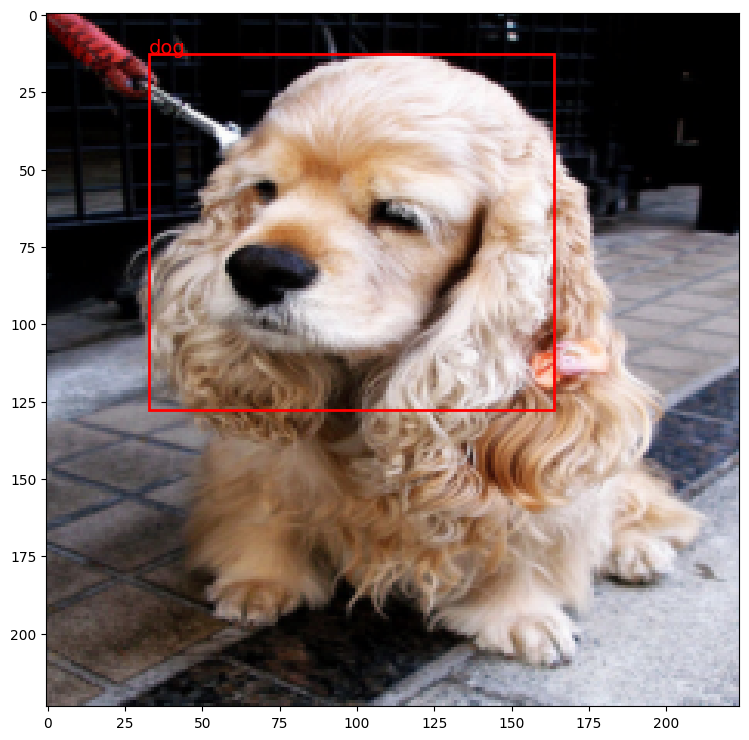

In [8]:
def imshow(img, label, bbox):
    image = np.copy(img[0])
    image = np.transpose(image, (1, 2, 0))
    image *= np.array([0.229, 0.224, 0.225])
    image += np.array([0.485, 0.456, 0.406])
    label = label[0]
    bbox = bbox[0]
    plt.figure();
    fig, ax = plt.subplots(1, figsize=(12,9));
    ax.imshow(image);
    x1, y1, x2, y2 = bbox.numpy().reshape(-1) * 224
    box_w, box_h = np.abs(x2-x1), np.abs(y2-y1)
    bbox = patches.Rectangle((x1, y1), box_w, box_h, linewidth=2, 
                             edgecolor='r', facecolor='none');
    ax.add_patch(bbox);
    ax.annotate(classes[label], (x1, y1), color='r', fontsize=14);

imshow(sample['image'],sample['label'],sample['bbox'])

In [21]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Load the pretrained ResNet-18 network and replace the top fully connected #
        # layer, so we could use the features of the network and not the only       #
        # the classification layer which carries significantly less information.    #
        # Afterwards, create a new sequential model with the remaining layers of    #
        # the pretrained network. Next, define two additional models that take as   #
        # input the extracted features and output the class scores and bounding box #
        # coordinates.                                                              #
        # Clarrification - You required to build 2 models - one for classification  #
        # and one for detection.                                                    #
        # The classification model is of shape: resent_features -> FC/FCs -> scores.#
        # The detection model is of shape: resent_features -> FC/FCs -> bbox.       #
        # You may train/leave frozen the resent_features backbone, try              #
        # experimenting with it.                                                    #
        # This function has no return value.                                        #
        #############################################################################
        self.resnet18 = nn.Sequential(*list(resnet18.children())[:-1])  
        self.flatten = nn.Flatten()

        self.classification = nn.Sequential(
            nn.Linear(512, num_classes)
        )

        self.detection = nn.Sequential(
            nn.Linear(512, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 4)
        )
        self.lamda = nn.Parameter(torch.tensor(1.0))
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def forward(self, images):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and extract the feature vector. In this case, when using a        #
        # predefined network, you don't want to change it's weights.                #
        # The rest of the layers you defined should accepts gradients for them to   #
        # improve during training.                                                  #
        # This function returns a class predication and a bounding box coordinates. #
        #############################################################################
        with torch.no_grad():
            features = self.resnet18(images)
        features = self.flatten(features)
        
        class_scores = self.classification(features)
        bbox = self.detection(features)
        return class_scores, bbox

        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

## Guidelines

1. Complete the `train_model` function in the cell below. This function takes as input the model and additional hyper-parameters, and outputs the best model found on the validation set. 
2. To babysit the learning process, **you must track the classification accuracy, IoU score and loss on the training and validation datasets and visualize them** (using matplotlib or similar). I have included an implementation of the IoU metric in the file `data\dataloader.py`.
3. Do not perform a massive grid search. Use papers, blogs, MOOCs and online guides to research best hyper-parameters for your model.
4. You are encouraged to try Google Colab. If you have an CUDA capable GPU at home - you are welcome to use it.
5. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
6. Training large neural networks may take a while. Make sure your code runs reasonably fast (~15 minutes on CPU and ~5 minutes on GPU).
7. Try to reach at least 90% classification accuracy and a IOU score of at least 0.60 on the validation set.
8. **In order to get full marks for this section explain the results and include visualizations.**.
9. You are given a general skeleton for the training function. Feel free to use any different structure.

In [22]:
def train_model(model, criterion_cls, criterion_bbox, optimizer, scheduler=None, num_epochs=5):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict()) # this is how a model is copied
    best_acc = 0.0

    train_loss_values = []
    val_loss_values = []
    train_acc_values = []
    val_acc_values = []
    train_iou_values = []
    val_iou_values = []


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0   # total loss of the network at each epoch
            running_corrects = 0 # number of correct predictions
            iou = 0.0            # IoU score
            
            # Iterate over data.
            for sample in dataloaders[phase]:
                #############################################################################
                # TO DO:                                                                    #
                # Extract the data from the dataloader, calculate the predictions of your   #
                # network and calculate the loss of the classification and bounding box     #
                # prediction. When in training mode, back-prop and update the weights.      #
                # At each epoch, calculate the test and train accuracy and IoU.             #
                # This function returns the best model in terms of accuracy.                #
                #############################################################################
                inputs, labels, bbox = sample['image'], sample['label'], sample['bbox']

                predicated_cls, predicated_bbox = model(inputs)

                loss_cls = criterion_cls(predicated_cls, labels)
                loss_bbox = criterion_bbox(predicated_bbox, bbox)


                loss = loss_cls + model.lamda * loss_bbox

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item()
                running_corrects += (predicated_cls.argmax(dim=1) == labels).sum().item()
                
                for predicted_box, true_box in zip(predicated_bbox, bbox):
                    iou += bb_intersection_over_union(predicted_box, true_box)
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            iou = iou.item() / dataset_sizes[phase]

            if phase == 'train':
                train_loss_values.append(epoch_loss)
                train_acc_values.append(epoch_acc)
                train_iou_values.append(iou)
            else:
                val_loss_values.append(epoch_loss)
                val_acc_values.append(epoch_acc)
                val_iou_values.append(iou)
            
            print('{} Loss: {:.4f}  |  Acc: {:.4f}  |  IOU: {:.4f}'.format(
                phase, epoch_loss, epoch_acc, iou))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_values, val_loss_values, train_acc_values, val_acc_values, train_iou_values, val_iou_values

Choose your optimizer and the loss functions for the classification and bounding box regression.

In [23]:
import torch.optim as optim

cnn = CNN(2)
cnn = cnn.to(device)

criterion_cls = None
criterion_bbox = None
optimizer = None
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
criterion_cls = torch.nn.CrossEntropyLoss()
criterion_bbox = torch.nn.MSELoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [24]:
best_model, train_loss_values, val_loss_values, train_acc_values, val_acc_values, train_iou_values, val_iou_values = train_model(cnn, criterion_cls, criterion_bbox, optimizer, num_epochs=10)

Epoch 1/10
----------


train Loss: 0.0171  |  Acc: 0.7704  |  IOU: 0.6678
val Loss: 0.0090  |  Acc: 0.9367  |  IOU: 0.7284
Epoch 2/10
----------
train Loss: 0.0080  |  Acc: 0.9340  |  IOU: 0.7372
val Loss: 0.0052  |  Acc: 0.9684  |  IOU: 0.7453
Epoch 3/10
----------
train Loss: 0.0055  |  Acc: 0.9481  |  IOU: 0.7493
val Loss: 0.0039  |  Acc: 0.9810  |  IOU: 0.7448
Epoch 4/10
----------
train Loss: 0.0041  |  Acc: 0.9733  |  IOU: 0.7624
val Loss: 0.0031  |  Acc: 0.9873  |  IOU: 0.7584
Epoch 5/10
----------
train Loss: 0.0031  |  Acc: 0.9874  |  IOU: 0.7681
val Loss: 0.0027  |  Acc: 0.9873  |  IOU: 0.7473
Epoch 6/10
----------
train Loss: 0.0028  |  Acc: 0.9874  |  IOU: 0.7759
val Loss: 0.0024  |  Acc: 0.9873  |  IOU: 0.7590
Epoch 7/10
----------
train Loss: 0.0035  |  Acc: 0.9701  |  IOU: 0.7817
val Loss: 0.0022  |  Acc: 0.9873  |  IOU: 0.7613
Epoch 8/10
----------
train Loss: 0.0036  |  Acc: 0.9686  |  IOU: 0.7803
val Loss: 0.0022  |  Acc: 0.9873  |  IOU: 0.7567
Epoch 9/10
----------
train Loss: 0.0021  |  A

Once you are pleased with your results, see how your model can predict and localize cats and dogs!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 1200x800 with 0 Axes>

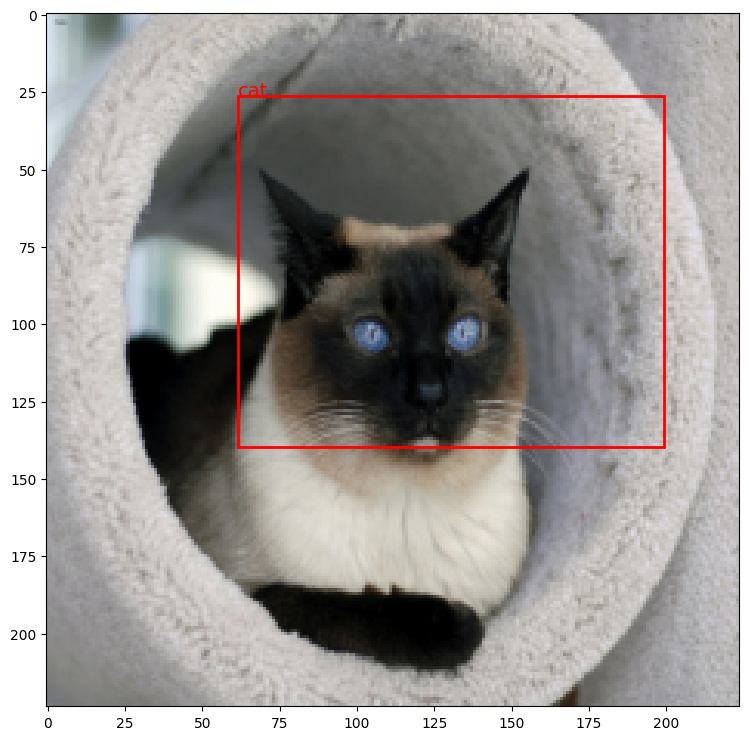

In [25]:
# Get a batch of validation data
sample = next(iter(dataloaders['val']))
with torch.no_grad():
    images = sample['image']
    images = images.to(device)
    label_pred, bbox_pred = best_model(images)
    _, label_pred = torch.max(label_pred, 1)
imshow(sample['image'], label_pred.cpu(), bbox_pred.cpu())

Your visualizations here (IoU / Accuracy / Loss on training and validation datasets as a function of the epoch). Only visualize the results of your best model.

In [26]:
plt.rcParams['figure.figsize'] = (8, 6) # set default size of plots

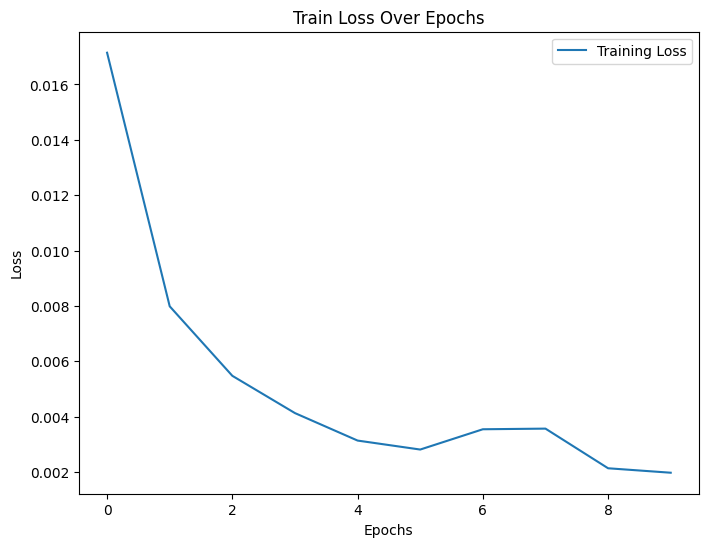

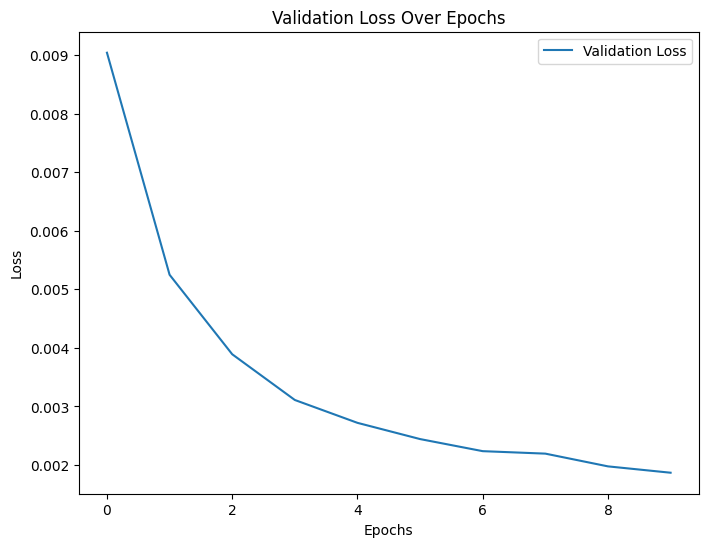

In [27]:
# Plotting the training loss
plt.plot(train_loss_values, label='Training Loss')
plt.title('Train Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting the validation loss
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


from the loss plots we can see that the model show signs of overfit after 5 epochs, but after 6 epochs both continue training and validation continue to decrease.

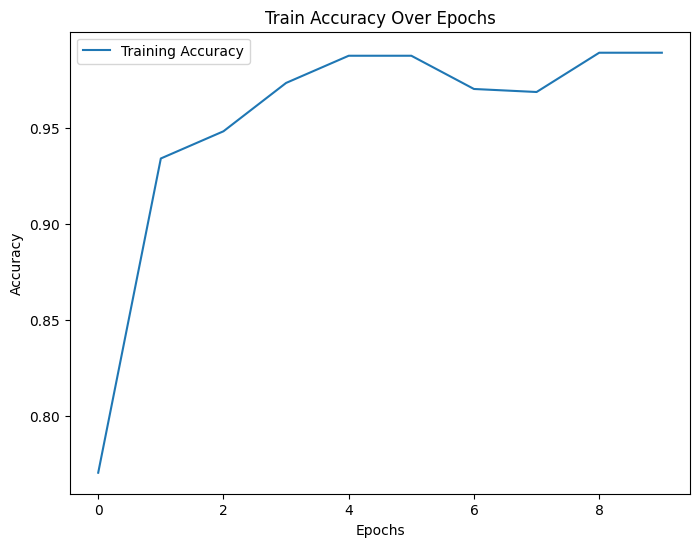

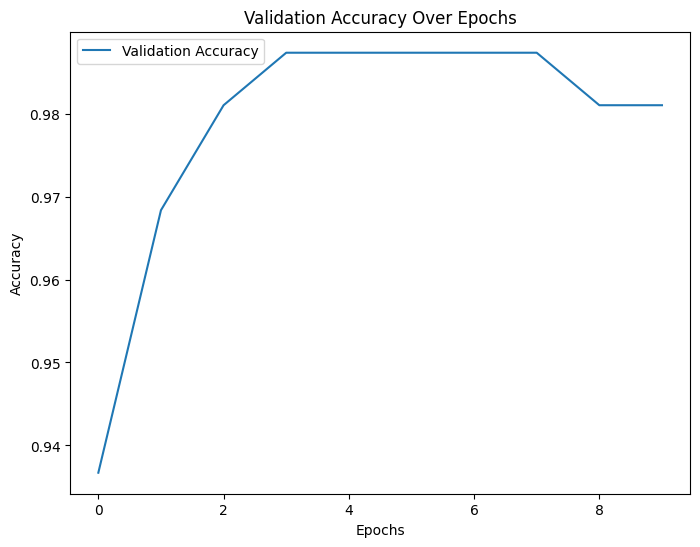

In [28]:
# Plotting the training accuracy
plt.plot(train_acc_values, label='Training Accuracy')
plt.title('Train Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting the validation accuracy
plt.plot(val_acc_values, label='Validation Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The accurcies plot shows that the model already starts from very high accuracy due to the pre-trained ResNet-18 model which already knows how to extract the best features for classifications.
as we saw in the loss plots the model exhibits small overfitting after the 5th epoch but get back on track in the 6th epoch.


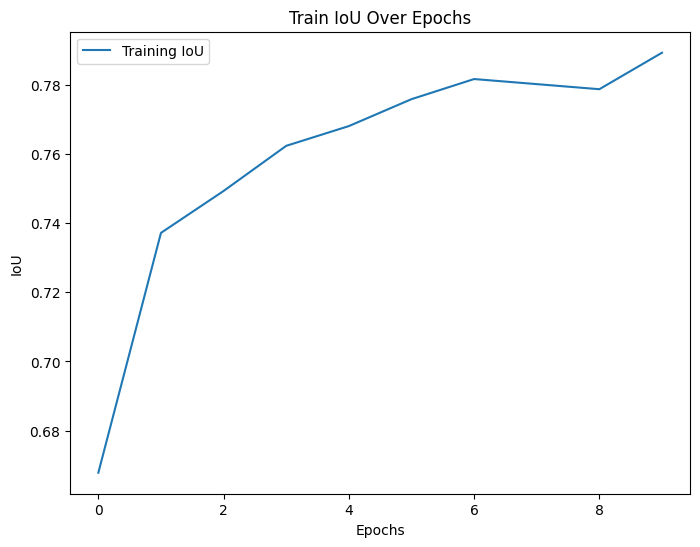

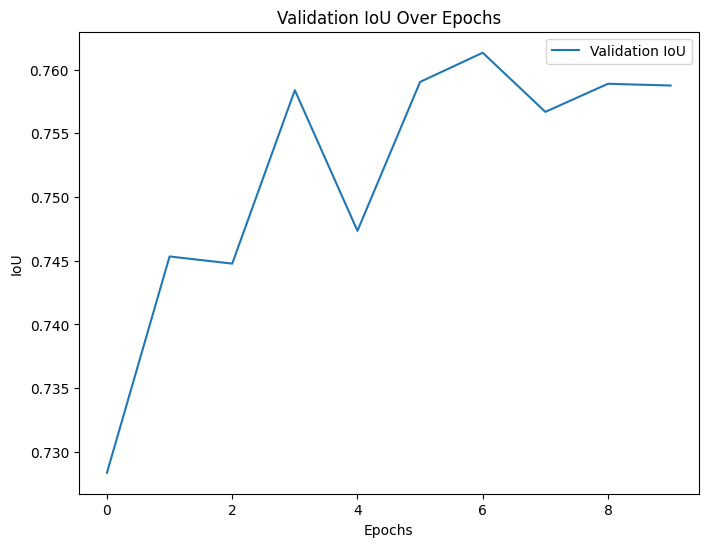

In [29]:
# Plotting the training IoU
plt.plot(train_iou_values, label='Training IoU')
plt.title('Train IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Plotting the validation IoU
plt.plot(val_iou_values, label='Validation IoU')
plt.title('Validation IoU Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

The Iou plot shows a bit of noisy trend on the validation set, but still in overall both the training and validation IoU are increasing.